# Introduction

Neutron star mergers and neutron star - black hole mergers have an optical counterpart called a kilonova.  The lightcurves of these kilonovae can be parameterized by four parameters.  Fitting the kilonovae light curves allows us to place constraints on the the parameters of the merger.  

- $M_{ej}^{dyn}$ - the ejecta mass during the merger
- $M_{ej}^{wind}$ - the ejecta mass due to the disk wind
- $\Phi$ - related to the chemical composition of the ejected mass
- $\theta_{obs}$ - the oberserver's viewing angle

The model is not analytical, so we need some form of interpolation.  Pervious studies (and homework 8) have used Gaussian Process Regression.  This method works, but can be slow and cumbersome.  We think it will be faster to use PCA and a neural network to fit model light curves to the data.  

#  Part 1: PCA preprocessing for our training lightcurves

The part 1 is the PCA transformation of our data. PCA reduces reduces dimensionality while preserving the most important information. The first part contains the transformation of the light curves on our training data. I sampled 26 points (time = 0.1, 0.3, 0.5, ….. 5.0) from each of 9 bands. There are 2156 light curves. So, I assembled them into a 2156 * 22 matrix. Applying PCA transformation reduced each band to 6 data points. Therefore, the result is a 2156 * 6 matrix per band. 

In [66]:
import pandas as pd
import os
import sys
import glob
import numpy as np
from scipy.interpolate import interpolate as interp
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn as sk
import emcee
from astropy.time import Time
import scipy as sp
import scipy.stats as st
import corner
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from numpy import sqrt
%matplotlib inline
from IPython.display import Image
import time

In [2]:
def read_files(files, tt, filts):

    names = []
    mags = {}
    for filename in files:
        name = filename.replace(".txt","").replace(".dat","").split("/")[-1]
        mag_d = np.loadtxt(filename)

        t = mag_d[:,0]
        mags[name] = {}
        mags[name]["t"] = mag_d[:,0]
        mags[name]["u"] = mag_d[:,1]
        mags[name]["g"] = mag_d[:,2]
        mags[name]["r"] = mag_d[:,3]
        mags[name]["i"] = mag_d[:,4]
        mags[name]["z"] = mag_d[:,5]
        mags[name]["y"] = mag_d[:,6]
        mags[name]["J"] = mag_d[:,7]
        mags[name]["H"] = mag_d[:,8]
        mags[name]["K"] = mag_d[:,9]

        names.append(name)

    magkeys = mags.keys()    
    for jj, key in enumerate(magkeys):
        keySplit = key.split("_")

        if "nsns" in key:

            mejdyn = float(keySplit[2].replace("mejdyn",""))
            mejwind = float(keySplit[3].replace("mejwind",""))
            phi0 = float(keySplit[4].replace("phi",""))
            theta = float(keySplit[5])

            mags[key]["mej_dyn"] = mejdyn
            mags[key]["mej_wind"] = mejwind
            mags[key]["phi"] = phi0
            mags[key]["theta"] = theta

        elif "nsbh" in key:

            mej_dyn = float(keySplit[2].replace("mejdyn",""))
            mej_wind = float(keySplit[3].replace("mejwind",""))
            phi = float(keySplit[4].replace("phi",""))
            theta = float(keySplit[5])

            mags[key]["mej_dyn"] = mej_dyn
            mags[key]["mej_wind"] = mej_wind
            #mags[key]["phi"] = phi
            mags[key]["theta"] = theta
           
        # Interpolate data onto grid
        mags[key]["data"] = np.zeros((len(tt),len(filts)))
        for jj,filt in enumerate(filts):
            ii = np.where(np.isfinite(mags[key][filt]))[0]
            f = interp.interp1d(mags[key]["t"][ii], mags[key][filt][ii], fill_value='extrapolate')
            maginterp = f(tt)
            mags[key]["data"][:,jj] = maginterp
        mags[key]["data_vector"] = np.reshape(mags[key]["data"],(len(tt)*len(filts),1))
            
    return mags

### Load our training data 

In [3]:
# The array of post-merger times we'll use to examine each lightcurve
tini, tmax, dt = 0.1, 5.0, 0.2 
tt = np.arange(tini,tmax+dt,dt) # 

# The filters we'll be focusing on
filts = ["u","g","r","i","z","y","J","H","K"]
# The model type we'll be focusing on
objtype = "BNS" # for "binary neutron star" -- can also choose "NSBH" for "neutron star - black hole"

# Defines the files containing model data
dataDir = "data/%s" % objtype
filenames = glob.glob('%s/*.dat'%dataDir)

# Loads the model data
models = read_files(filenames, tt, filts)
modelkeys = list(models.keys())

### Process data

After loading the data, I placed light curve magnitudes and observing times into a dictionary, and their correponding paramters into an array. 

In [7]:
# Place the relevant parameters into an array
svd_model = {}
# Loop through filters
for jj,filt in enumerate(filts):
    mag_array = []
    for key in modelkeys:
        mag_array.append(models[key]["data"][:,jj])

    mag_array_postprocess = np.array(mag_array)
    mag_array_postprocess[np.isnan(mag_array_postprocess)]=0.0
    
    svd_model[filt] = {}
    svd_model[filt]["tt"] = tt
    svd_model[filt]["mag_array_postprocess"] = mag_array_postprocess

In [8]:
# Place the relevant parameters into an array
param_array = []
for key in modelkeys:
    if objtype == "BNS":
        param_array.append([np.log10(models[key]["mej_dyn"]),np.log10(models[key]["mej_wind"]),models[key]["phi"],models[key]["theta"]])
    elif objtype == "NSBH":
        param_array.append([np.log10(models[key]["mej_dyn"]),np.log10(models[key]["mej_wind"]),models[key]["theta"]])
param_array_postprocess = np.array(param_array)

### PCA components transfomration

I used the SKlearn PCA package to transform our DATA and stored PCA components in a data frame for later visualization.

In [9]:
from sklearn.decomposition import PCA

pca_uBand = PCA(n_components=6, svd_solver = 'auto')
pca_uBand_components = pca_uBand.fit_transform(svd_model['u']["mag_array_postprocess"] )

pca_gBand = PCA(n_components=6, svd_solver = 'auto')
pca_gBand_components = pca_gBand.fit_transform(svd_model['g']["mag_array_postprocess"] )

pca_rBand = PCA(n_components=6, svd_solver = 'auto')
pca_rBand_components = pca_rBand.fit_transform(svd_model['r']["mag_array_postprocess"] )

pca_iBand = PCA(n_components=6, svd_solver = 'auto')
pca_iBand_components = pca_iBand.fit_transform(svd_model['i']["mag_array_postprocess"] )

pca_zBand = PCA(n_components=6, svd_solver = 'auto')
pca_zBand_components = pca_zBand.fit_transform(svd_model['z']["mag_array_postprocess"] )

pca_yBand = PCA(n_components=6, svd_solver = 'auto')
pca_yBand_components = pca_yBand.fit_transform(svd_model['y']["mag_array_postprocess"] )

pca_JBand = PCA(n_components=6, svd_solver = 'auto')
pca_JBand_components = pca_JBand.fit_transform(svd_model['J']["mag_array_postprocess"] )

pca_HBand = PCA(n_components=6, svd_solver = 'auto')
pca_HBand_components = pca_HBand.fit_transform(svd_model['H']["mag_array_postprocess"] )

pca_KBand = PCA(n_components=6, svd_solver = 'auto')
pca_KBand_components = pca_KBand.fit_transform(svd_model['K']["mag_array_postprocess"] )

In [10]:
pca_df_uband = pd.DataFrame(data = pca_uBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_gband = pd.DataFrame(data = pca_gBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_rband = pd.DataFrame(data = pca_rBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_iband = pd.DataFrame(data = pca_iBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_zband = pd.DataFrame(data = pca_zBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_yband = pd.DataFrame(data = pca_yBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_Jband = pd.DataFrame(data = pca_JBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_Hband = pd.DataFrame(data = pca_HBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
pca_df_Kband = pd.DataFrame(data = pca_KBand_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])

Here are the scree plots of our PCA reduction, they tell the portion of variance explained by each component. 

Text(0, 0.5, 'Proportion of Variance Explained')

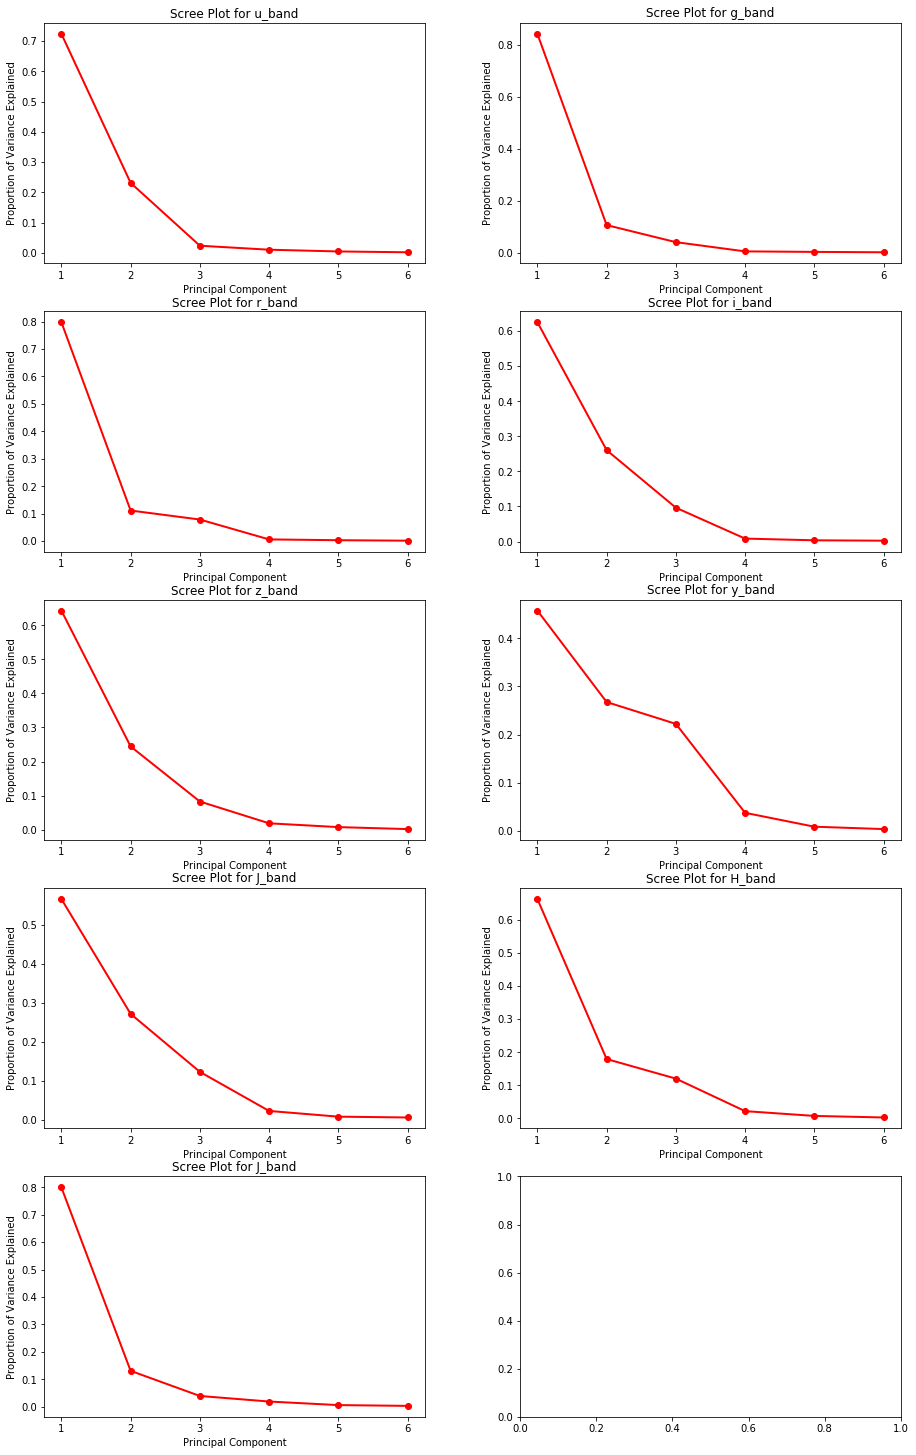

In [11]:
fig, ax = plt.subplots(5, 2, figsize=(14, 22))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95,
                    bottom=0.07, top=0.95)

PC_values = np.arange(6) + 1
ax[0,0].plot(PC_values, pca_uBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[0,0].set_title('Scree Plot for u_band')
ax[0,0].set_xlabel('Principal Component')
ax[0,0].set_ylabel('Proportion of Variance Explained')

ax[0,1].plot(PC_values, pca_gBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[0,1].set_title('Scree Plot for g_band')
ax[0,1].set_xlabel('Principal Component')
ax[0,1].set_ylabel('Proportion of Variance Explained')

ax[1,0].plot(PC_values, pca_rBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[1,0].set_title('Scree Plot for r_band')
ax[1,0].set_xlabel('Principal Component')
ax[1,0].set_ylabel('Proportion of Variance Explained')

ax[1,1].plot(PC_values, pca_iBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[1,1].set_title('Scree Plot for i_band')
ax[1,1].set_xlabel('Principal Component')
ax[1,1].set_ylabel('Proportion of Variance Explained')

ax[2,0].plot(PC_values, pca_zBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[2,0].set_title('Scree Plot for z_band')
ax[2,0].set_xlabel('Principal Component')
ax[2,0].set_ylabel('Proportion of Variance Explained')

ax[2,1].plot(PC_values, pca_yBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[2,1].set_title('Scree Plot for y_band')
ax[2,1].set_xlabel('Principal Component')
ax[2,1].set_ylabel('Proportion of Variance Explained')

ax[3,0].plot(PC_values, pca_JBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[3,0].set_title('Scree Plot for J_band')
ax[3,0].set_xlabel('Principal Component')
ax[3,0].set_ylabel('Proportion of Variance Explained')

ax[3,1].plot(PC_values, pca_HBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[3,1].set_title('Scree Plot for H_band')
ax[3,1].set_xlabel('Principal Component')
ax[3,1].set_ylabel('Proportion of Variance Explained')

ax[4,0].plot(PC_values, pca_KBand.explained_variance_ratio_, 'ro-', linewidth=2)
ax[4,0].set_title('Scree Plot for J_band')
ax[4,0].set_xlabel('Principal Component')
ax[4,0].set_ylabel('Proportion of Variance Explained')



### 6 components 

In [12]:
Input_pca_uBand_6components = pca_uBand_components
Input_pca_gBand_6components = pca_gBand_components
Input_pca_rBand_6components = pca_rBand_components
Input_pca_iBand_6components = pca_iBand_components
Input_pca_zBand_6components = pca_zBand_components
Input_pca_yBand_6components = pca_yBand_components
Input_pca_JBand_6components = pca_JBand_components
Input_pca_HBand_6components = pca_HBand_components
Input_pca_KBand_6components = pca_KBand_components

### Here are the code that can transfer the pca components back.

In [14]:
pca_uBand_back = pca_uBand.inverse_transform(pca_uBand_components)
pca_gBand_back = pca_gBand.inverse_transform(pca_gBand_components)
pca_rBand_back = pca_rBand.inverse_transform(pca_rBand_components)
pca_iBand_back = pca_iBand.inverse_transform(pca_iBand_components)
pca_zBand_back = pca_zBand.inverse_transform(pca_zBand_components)
pca_yBand_back = pca_yBand.inverse_transform(pca_yBand_components)
pca_JBand_back = pca_JBand.inverse_transform(pca_JBand_components)
pca_HBand_back = pca_HBand.inverse_transform(pca_HBand_components)
pca_KBand_back = pca_KBand.inverse_transform(pca_KBand_components)

# Part 2: PCA preprocessing for our test lightcurve (GW170817)

### load our test data

In [15]:
def loadEvent(filename):
    lines = [line.rstrip('\n') for line in open(filename)]
    lines = filter(None,lines)

    data = {}
    for line in lines:
        lineSplit = line.split(" ")
        lineSplit = list(filter(None,lineSplit))
        mjd = Time(lineSplit[0], format='isot').mjd
        filt = lineSplit[1]
        mag = float(lineSplit[2])
        dmag = float(lineSplit[3])

        if not filt in data:
            data[filt] = np.empty((0,3), float)
        data[filt] = np.append(data[filt],np.array([[mjd,mag,dmag]]),axis=0)

    return data 
    
filename = "data/GW170817.dat"
T0 = 57982.5285236896 # Merger time
distance = 40

data_out = loadEvent(filename)

for ii,key in enumerate(list(data_out.keys())):
    if key == "t":
        continue
    else:
        data_out[key][:,0] = data_out[key][:,0] - T0
        data_out[key][:,1] = data_out[key][:,1] - 5*(np.log10(distance*1e6) - 1)

for ii,key in enumerate(list(data_out.keys())):
    if key == "t":
        continue
    else:
        idxs = np.intersect1d(np.where(data_out[key][:,0]>=tini)[0],np.where(data_out[key][:,0]<=tmax)[0])
        data_out[key] = data_out[key][idxs,:]

for ii,key in enumerate(list(data_out.keys())):
    idxs = np.where(~np.isnan(data_out[key][:,2]))[0]
    if key == "t":
        continue
    else:
        data_out[key] = data_out[key][idxs,:]

## added this to remove infs as well
# for ii,key in enumerate(list(data_out.keys())):
#     idxs = np.where(~np.isinf(data_out[key][:,2]))[0]
#     if key == "t":
#         continue
#     else:
#         data_out[key] = data_out[key][idxs,:]
        
for ii,key in enumerate(list(data_out.keys())):
    if not key in filts:
        del data_out[key]

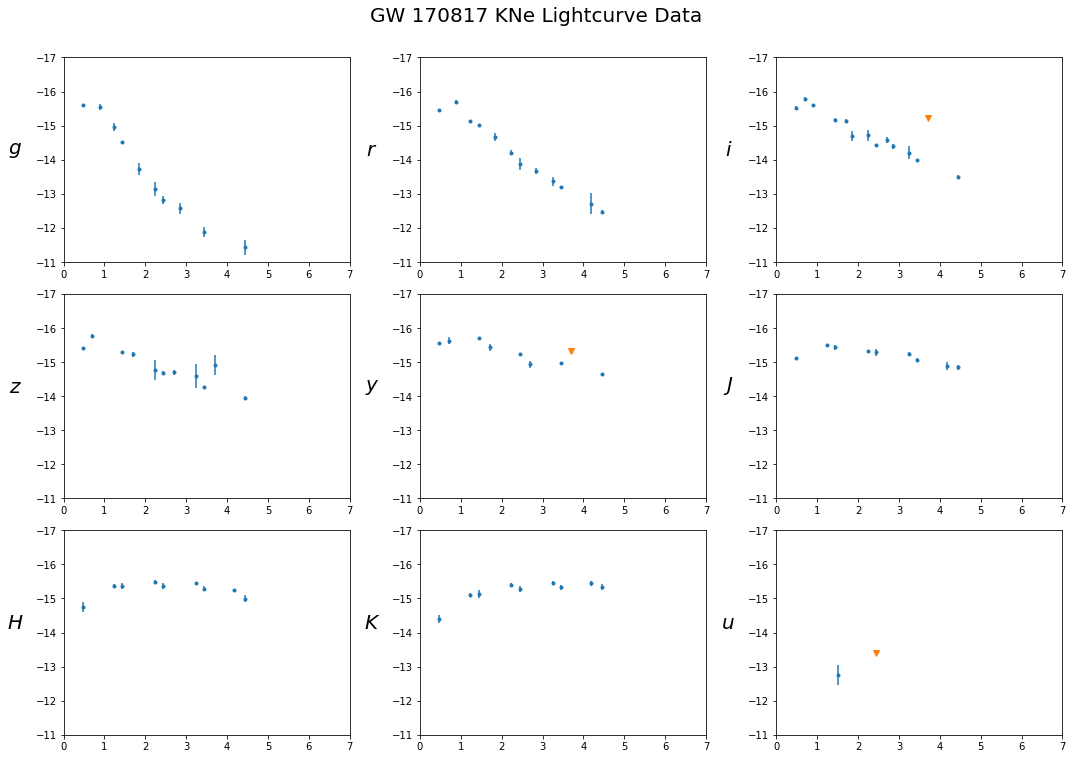

In [16]:
## plot the KNe lightcurves
fig, axes = plt.subplots(3,3,figsize=(15,10))
for filt, ax in zip(data_out.keys(),axes.flatten()):

    data = data_out[filt]
    t, y, sigma_y = data[:,0], data[:,1], data[:,2]
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]
    idx = np.where(np.isfinite(sigma_y))[0]
    ax.errorbar(t[idx],y[idx],sigma_y[idx],fmt='.', label='%s-band'%filt)

    idx = np.where(~np.isfinite(sigma_y))[0]
    ax.errorbar(t[idx],y[idx],sigma_y[idx],fmt='v')

    ax.set_xlim([0.0, 7])
    ax.set_ylim([-17.0,-11.0])
    ax.invert_yaxis()
    
    ax.set_ylabel(r'$%s$'%filt,fontsize=20,rotation=0,labelpad=20)
fig.suptitle('GW 170817 KNe Lightcurve Data',fontsize=20,y=1.05)
plt.tight_layout()
plt.show()

### Step two: Interpolate sample points 

In [17]:
f_u = interp.interp1d(data_out['u'][:,0], data_out['u'][:,1], fill_value='extrapolate')
maginterp_u = f_u(tt)

f_g = interp.interp1d(data_out['g'][:,0], data_out['g'][:,1], fill_value='extrapolate')
maginterp_g = f_g(tt)

f_r = interp.interp1d(data_out['r'][:,0], data_out['r'][:,1], fill_value='extrapolate')
maginterp_r = f_r(tt)

f_i = interp.interp1d(data_out['i'][:,0], data_out['i'][:,1], fill_value='extrapolate')
maginterp_i = f_i(tt)

f_z = interp.interp1d(data_out['z'][:,0], data_out['z'][:,1], fill_value='extrapolate')
maginterp_z = f_z(tt)

f_y = interp.interp1d(data_out['y'][:,0], data_out['y'][:,1], fill_value='extrapolate')
maginterp_y = f_y(tt)

f_J = interp.interp1d(data_out['J'][:,0], data_out['J'][:,1], fill_value='extrapolate')
maginterp_J = f_J(tt)

f_H = interp.interp1d(data_out['H'][:,0], data_out['H'][:,1], fill_value='extrapolate')
maginterp_H = f_H(tt)

f_K = interp.interp1d(data_out['K'][:,0], data_out['K'][:,1], fill_value='extrapolate')
maginterp_K = f_K(tt)

### Step three: PCA transformation 

### 6 components

In [18]:
Test_pca_uBand_6components= pca_uBand.transform(maginterp_u.reshape(-1,maginterp_u.shape[0]))
Test_pca_gBand_6components= pca_gBand.transform(maginterp_g.reshape(-1,maginterp_g.shape[0]))
Test_pca_rBand_6components= pca_rBand.transform(maginterp_r.reshape(-1,maginterp_r.shape[0]))
Test_pca_iBand_6components= pca_iBand.transform(maginterp_i.reshape(-1,maginterp_i.shape[0]))
Test_pca_zBand_6components= pca_zBand.transform(maginterp_z.reshape(-1,maginterp_z.shape[0]))
Test_pca_yBand_6components= pca_yBand.transform(maginterp_y.reshape(-1,maginterp_y.shape[0]))
Test_pca_JBand_6components= pca_JBand.transform(maginterp_J.reshape(-1,maginterp_J.shape[0]))
Test_pca_HBand_6components= pca_HBand.transform(maginterp_H.reshape(-1,maginterp_H.shape[0]))
Test_pca_KBand_6components= pca_KBand.transform(maginterp_K.reshape(-1,maginterp_K.shape[0]))

In [19]:
test_X = np.concatenate((Test_pca_iBand_6components, Test_pca_gBand_6components, Test_pca_uBand_6components,\
                         Test_pca_rBand_6components, Test_pca_zBand_6components, Test_pca_yBand_6components,\
                         Test_pca_JBand_6components, Test_pca_HBand_6components, Test_pca_KBand_6components), axis=1)
print('Shape of test_X: ', test_X.shape)

Shape of test_X:  (1, 54)


# Part 3: Train Neural Network

### Prepare training data

In [20]:
train_y = np.concatenate((Input_pca_iBand_6components, Input_pca_gBand_6components, Input_pca_uBand_6components,\
                          Input_pca_rBand_6components, Input_pca_zBand_6components, Input_pca_yBand_6components,\
                          Input_pca_JBand_6components, Input_pca_HBand_6components, Input_pca_KBand_6components), axis=1)
train_X = param_array_postprocess.copy()
print("shape of X:", train_X.shape, " shape of y:", train_y.shape)

shape of X: (2156, 4)  shape of y: (2156, 54)


#### Training set info

There are 2156 instances, each instance has 4 parameters. The ground truth of each instance is 54 PCA components (6 components on 9 bands).

### Option 1: Using built-in MLPregressor of Scikit-learn

In [21]:
# scaler = StandardScaler()
# scaler.fit(train_X)
# train_X = scaler.transform(train_X)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, shuffle=True, test_size=0.1, random_state=8581)

regr_sklearn = MLPRegressor(random_state=1, max_iter=2000, solver='adam').fit(train_X, train_y)
print("MSE: ", mean_squared_error(val_y, regr_sklearn.predict(val_X)))

MSE:  6.22056309960119


### Option 2: Using custom neural network

![alt text](./figures/nn.png "Title")

In [22]:
np.random.RandomState(42)
model = Sequential()
model.add(Dense(train_X.shape[1], activation='relu', kernel_initializer='he_normal', input_shape=(train_X.shape[1],)))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(54))
# compile the model
model.compile(optimizer='adam', loss='mse')
# fit the model
train_history = model.fit(train_X, train_y, epochs=2000, batch_size=32, verbose=0, validation_data=(val_X, val_y))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


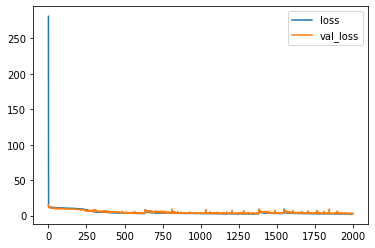

In [23]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [24]:
# evaluate the model
error = model.evaluate(val_X, val_y, verbose=0)
print("MSE: ", error)

MSE:  3.172043544274789


### Now we have two regressor: regr_sklearn, model. Use .predict() to get prediction on test dataset.

In [27]:
## now we load our very nice model that we produced via the above process but got very lucky on
model = tf.keras.models.load_model('models/1p47MSE_mod')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Let's take a look at the lightcurves the NN produces compared to the original model lightcurves.

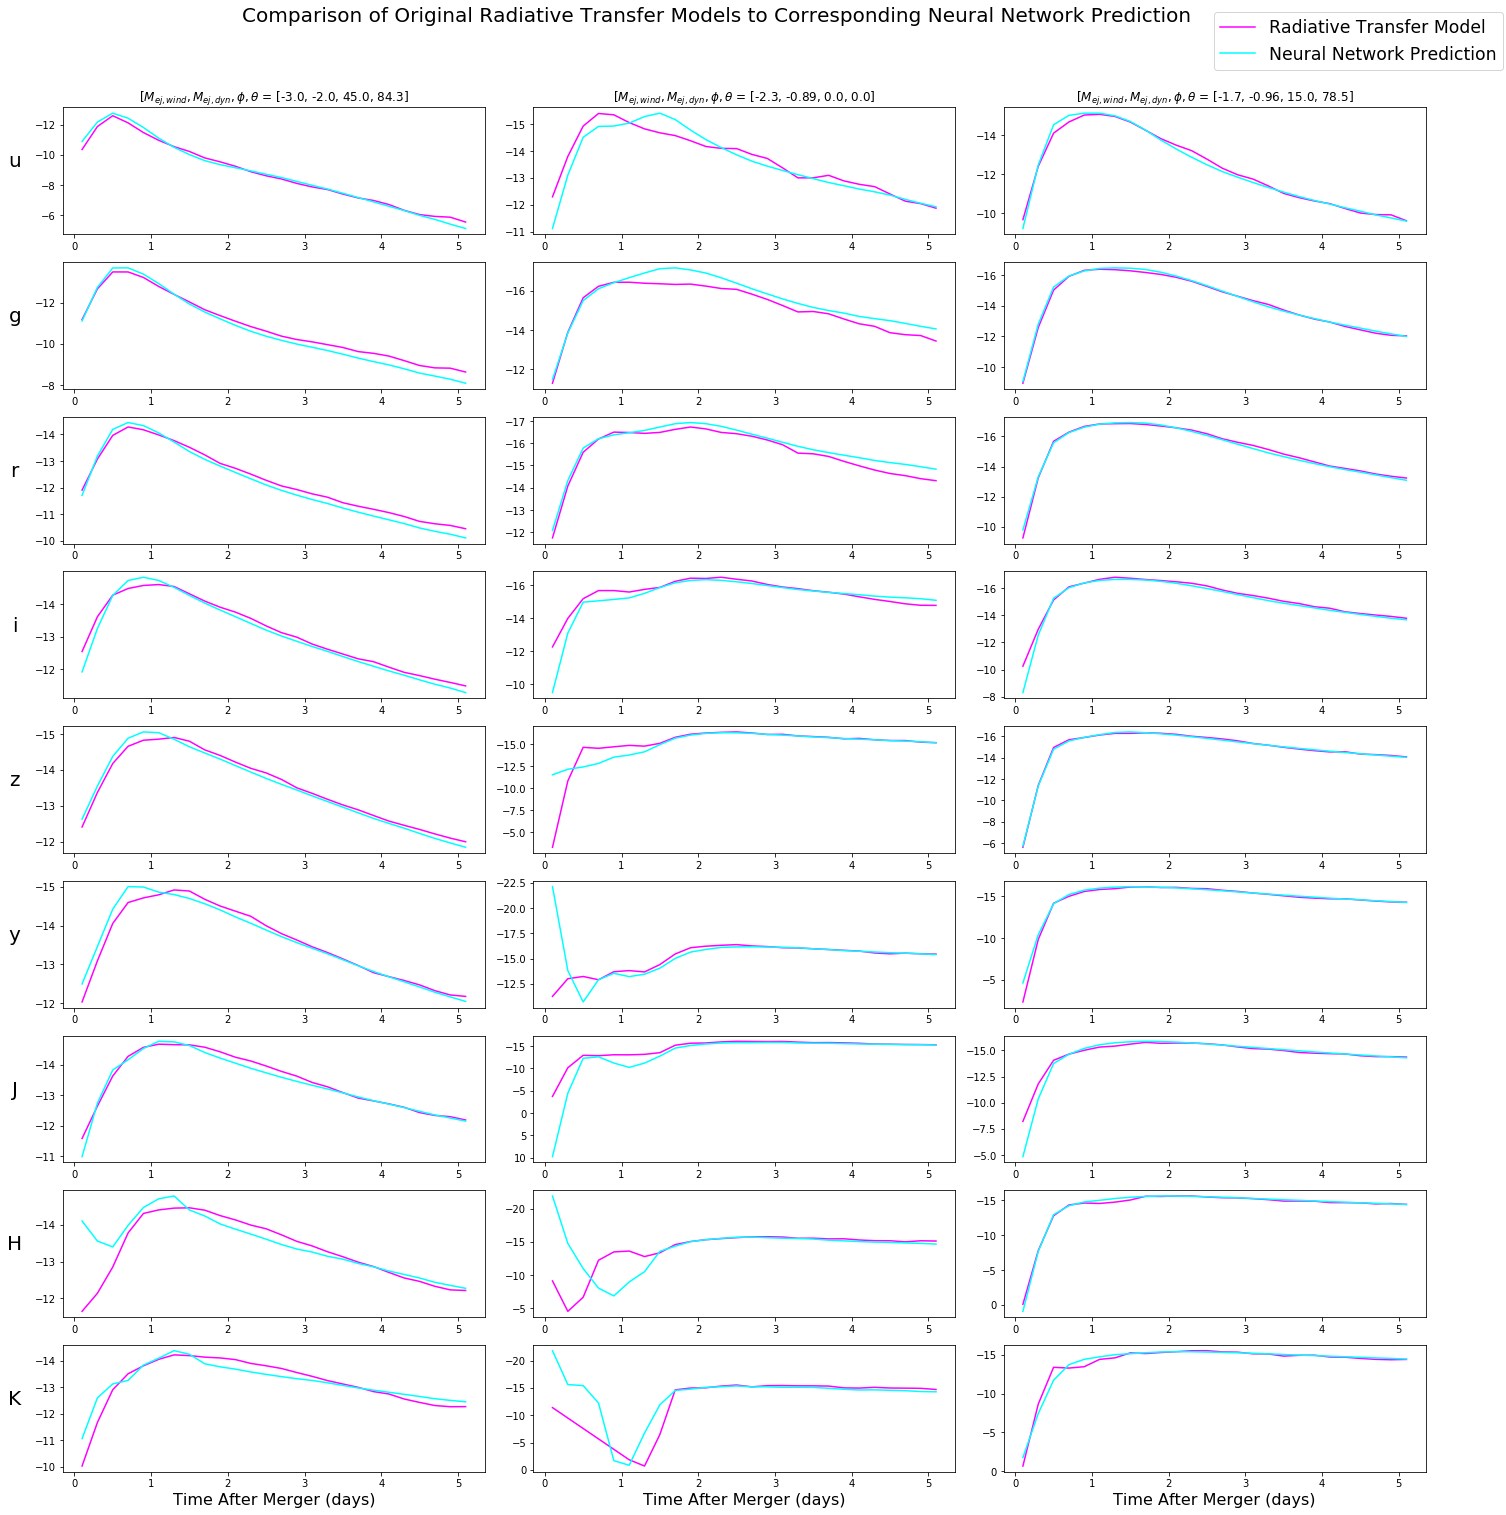

In [28]:
## arbitrarily select a couple model lightcurves
lcs_list = [42,1001,2021]
fig, axes = plt.subplots(9,3,figsize=(20,20))
for n, x in zip(lcs_list,range(axes.shape[1])):
    modpar = param_array_postprocess[n,:]
    title_list = str([round(i, 2) for i in modpar])
    axes[0,x].set_title('$[M_{ej,wind},M_{ej,dyn},\phi,\\theta$ = '+title_list)
    
    pca_pred = model.predict(modpar.reshape(1,-1))[0,:]
    
    ## split PCA by band
    PCA_list = np.array_split(pca_pred,len(filts))
    
    ## out of order b/c it needs to match NN
    pca_uBand_back = pca_uBand.inverse_transform(PCA_list[2])
    pca_gBand_back = pca_gBand.inverse_transform(PCA_list[1])
    pca_rBand_back = pca_rBand.inverse_transform(PCA_list[3])
    pca_iBand_back = pca_iBand.inverse_transform(PCA_list[0])
    pca_zBand_back = pca_zBand.inverse_transform(PCA_list[4])
    pca_yBand_back = pca_yBand.inverse_transform(PCA_list[5])
    pca_JBand_back = pca_JBand.inverse_transform(PCA_list[6])
    pca_HBand_back = pca_HBand.inverse_transform(PCA_list[7])
    pca_KBand_back = pca_KBand.inverse_transform(PCA_list[8])
    
    NN_mags = dict(zip(filts,[pca_uBand_back,pca_gBand_back,pca_rBand_back,pca_iBand_back,pca_zBand_back,pca_yBand_back,\
                           pca_JBand_back,pca_HBand_back,pca_KBand_back]))
    
    for filt, y in zip(filts,range(axes.shape[0])):
        modmag = svd_model[filt]["mag_array_postprocess"][n,:]
        times = svd_model[filt]["tt"]
        predmag = NN_mags[filt]
        l1, = axes[y,x].plot(times,modmag,c='magenta')
        l2, = axes[y,x].plot(times,predmag,c='cyan')
        axes[y,x].invert_yaxis()

for y, filt in zip(range(axes.shape[0]),filts):
    axes[y,0].set_ylabel(filt,fontsize=20,rotation=0,labelpad=20)
for x in range(axes.shape[1]):
    axes[-1,x].set_xlabel('Time After Merger (days)',fontsize=16)
l1.set_label('Radiative Transfer Model')
l2.set_label('Neural Network Prediction')
fig.legend(fontsize='xx-large',loc='upper right',bbox_to_anchor=(1.05,1.05))
fig.suptitle('Comparison of Original Radiative Transfer Models to Corresponding Neural Network Prediction',fontsize=20,y=1.05)

plt.tight_layout()
plt.show()

## Reconstruction Errors ##

Here we compare the neural network's reconstructions for the parameters corresponding to our known model lightcurves and get statistics on the residuals by band.

In [33]:
lcs_list = range(len(modelkeys))
theta_arr = np.zeros((len(modelkeys),4))
filts = ["u","g","r","i","z","y","J","H","K"]

res_array = np.zeros((len(modelkeys),len(filts),len(tt)))

for i,key in enumerate(modelkeys):
        theta_arr[i,0] = models[key]['mej_wind']
        theta_arr[i,1] = models[key]['mej_dyn']
        theta_arr[i,2] = models[key]['phi']
        theta_arr[i,3] = models[key]['theta']
        
        
for n in lcs_list:
    
    model_lightcurve = model.predict(theta_arr[n,:].reshape(1,-1))[0,:]
    
    ## split PCA by band
    PCA_list = np.array_split(model_lightcurve,len(filts))
    
    ## out of order b/c it needs to match NN
    pca_uBand_back = pca_uBand.inverse_transform(PCA_list[2])
    pca_gBand_back = pca_gBand.inverse_transform(PCA_list[1])
    pca_rBand_back = pca_rBand.inverse_transform(PCA_list[3])
    pca_iBand_back = pca_iBand.inverse_transform(PCA_list[0])
    pca_zBand_back = pca_zBand.inverse_transform(PCA_list[4])
    pca_yBand_back = pca_yBand.inverse_transform(PCA_list[5])
    pca_JBand_back = pca_JBand.inverse_transform(PCA_list[6])
    pca_HBand_back = pca_HBand.inverse_transform(PCA_list[7])
    pca_KBand_back = pca_KBand.inverse_transform(PCA_list[8])
    
    NN_mags = dict(zip(filts,[pca_uBand_back,pca_gBand_back,pca_rBand_back,pca_iBand_back,pca_zBand_back,pca_yBand_back,\
                           pca_JBand_back,pca_HBand_back,pca_KBand_back]))
    
    
    for f,filt in enumerate(filts):
        modmag = svd_model[filt]["mag_array_postprocess"][n,:]
        times = svd_model[filt]["tt"]
        predmag = NN_mags[filt]
        
        
        resid_reconstruction = np.abs(modmag - predmag)
        res_array[n,f,:] = resid_reconstruction



In [34]:
#printing an example
print(res_array[34,1,:])

err_mean_arr = np.mean(res_array,axis=(0,2))
err_std_arr = np.std(res_array,axis=(0,2))

print(err_mean_arr)
print(err_std_arr)

[1.35138021 0.42724961 0.30910997 0.79375588 1.15609466 1.43560477
 1.70366563 1.94551138 1.98737017 1.91409384 1.95933476 1.92042737
 1.93474255 1.94699492 1.93173465 1.94356355 1.95674688 2.0009185
 2.07388822 2.106162   2.14662361 2.21238641 2.33121786 2.29628397
 2.38977436 2.38328778]
[1.27494502 1.29322663 1.06775453 0.84073029 0.90559613 0.90784671
 0.93624223 1.04149174 1.5258793 ]
[1.13152409 0.936031   0.76987616 0.71298731 1.4122984  1.46366746
 1.44918557 2.11727426 4.309942  ]


## Parameter Inference ##

Here, we reprocess the 170817 KNe data to remove data points that are upper limits (error = -inf). Ideally, we would treat these points more subtly, but to do so would be quite time consuming and complicated. We would have to model some distribution whose upper limit matches the observed limit and implement some sort of nested sampling or hierarchical approach. While that does sound fun, it would also be more involved than is needed for this project.

In [35]:
## reprocess the GW170817 KNe lightcurve

filename = "data/GW170817.dat"
T0 = 57982.5285236896 # Merger time
distance = 40

data_reproc = loadEvent(filename)

for ii,key in enumerate(list(data_reproc.keys())):
    if key == "t":
        continue
    else:
        data_reproc[key][:,0] = data_reproc[key][:,0] - T0
        data_reproc[key][:,1] = data_reproc[key][:,1] - 5*(np.log10(distance*1e6) - 1)

for ii,key in enumerate(list(data_reproc.keys())):
    if key == "t":
        continue
    else:
        idxs = np.intersect1d(np.where(data_reproc[key][:,0]>=tini)[0],np.where(data_reproc[key][:,0]<=tmax)[0])
        data_reproc[key] = data_reproc[key][idxs,:]

for ii,key in enumerate(list(data_reproc.keys())):
    idxs = np.where(~np.isnan(data_reproc[key][:,2]))[0]
    if key == "t":
        continue
    else:
        data_reproc[key] = data_reproc[key][idxs,:]

# added this to remove infs as well
for ii,key in enumerate(list(data_reproc.keys())):
    idxs = np.where(~np.isinf(data_reproc[key][:,2]))[0]
    if key == "t":
        continue
    else:
        data_reproc[key] = data_reproc[key][idxs,:]
        
for ii,key in enumerate(list(data_reproc.keys())):
    if not key in filts:
        del data_reproc[key]

In [36]:
## get range of parameter values

m_winds = np.zeros(len(modelkeys))
m_dyns = np.zeros(len(modelkeys))
phis = np.zeros(len(modelkeys))
thets = np.zeros(len(modelkeys))

for i,key in enumerate(modelkeys):
    m_winds[i] = models[key]['mej_wind']
    m_dyns[i] = models[key]['mej_dyn']
    phis[i] = models[key]['phi']
    thets[i] = models[key]['theta']

mwind_bounds = [np.min(m_winds),np.max(m_winds)]
print(f"[min, max] for M_ej_wind is ",mwind_bounds,"M_sun")
mdyn_bounds = [np.min(m_dyns),np.max(m_dyns)]
print(f"[min, max] for M_ej_dyn is ",mdyn_bounds,"M_sun")
phi_bounds = [np.min(phis),np.max(phis)]
print(f"[min, max] for phi is ",phi_bounds,"degrees")
theta_bounds = [np.min(thets),np.max(thets)]
print(f"[min, max] for theta is ",theta_bounds,"degrees")

[min, max] for M_ej_wind is  [0.01, 0.13] M_sun
[min, max] for M_ej_dyn is  [0.001, 0.02] M_sun
[min, max] for phi is  [0.0, 90.0] degrees
[min, max] for theta is  [0.0, 90.0] degrees


Our likelihood function:
- Takes in a set of four parameters ($M_{ej,wind}$, $M_{ej,dyn}$, $\phi$, and $\theta$)
- Calls our neural network to create the PCA representation of a model lightcurve
- Uses the PCA representation to reconstruct a lightcurve and interpolate to find values at the observed times
- Compares the data to the model lightcuve via a multivariate gaussian likelihood. The covariance matrix of this multivariate gaussian is determined by combining the variance from the measurement error with the variance inherent to the NN's accuracy and reconstruction error. (This latter point is a to-do/further work; we currently using a placeholder value for this error)
- returns logp(data|parameters)

In [37]:
'''
Log likelihood for KNe light curve inference. For a given parameter vector, 
it uses our neural network to compute a model lightcurve and compare it with the data.

Inputs: 
theta - array - parameter vector [log10(M_ej_wind), log10(M_ej_dyn), phi, theta]
td_data - dict - Observed light KNe curve
neural_network - neural network model - (regr_sklearn or model)
sim_times - array - time array used in original lightcurve models

Outputs:
logp - float - log likelihood of data given parameters
'''


def loglike(theta,ts_data,sim_times,neural_network=model,band_err_means=err_mean_arr):
    
    ## priors
    if ((theta[0] < -2) or (theta[0] > np.log10(0.13))):
        return -np.inf
    if ((theta[1] < -3) or (theta[1] > np.log10(0.02))):
        return -np.inf
    if ((theta[2] < 0) or (theta[2] > 90)):
        return -np.inf
    if ((theta[3] < 0) or (theta[3] > 90)):
        return -np.inf    
    
    ## call the neural network
    model_lightcurve = neural_network.predict(theta.reshape(1,-1))[0,:]
    
    ## list of bands
    ## out of order b/c it needs to match the NN
    bands = ['i','g','u','r','z','y','J','H','K']
    
    ## split PCA by band
    PCA_list = np.array_split(model_lightcurve,len(bands))
    
    ## initialize logp
    logp = 0
    
    ## out of order b/c it needs to match NN
    pca_uBand_back = pca_uBand.inverse_transform(PCA_list[2])
    pca_gBand_back = pca_gBand.inverse_transform(PCA_list[1])
    pca_rBand_back = pca_rBand.inverse_transform(PCA_list[3])
    pca_iBand_back = pca_iBand.inverse_transform(PCA_list[0])
    pca_zBand_back = pca_zBand.inverse_transform(PCA_list[4])
    pca_yBand_back = pca_yBand.inverse_transform(PCA_list[5])
    pca_JBand_back = pca_JBand.inverse_transform(PCA_list[6])
    pca_HBand_back = pca_HBand.inverse_transform(PCA_list[7])
    pca_KBand_back = pca_KBand.inverse_transform(PCA_list[8])
    
    PCA_list_transformed = [pca_uBand_back,pca_gBand_back,pca_rBand_back,pca_iBand_back,pca_zBand_back,pca_yBand_back,\
                           pca_JBand_back,pca_HBand_back,pca_KBand_back]
    
    ## loop over magnitude bands
    for band, PCA, recon_err in zip(bands,PCA_list_transformed,band_err_means):
        ## extract times, magnitudes, and errors
        times = ts_data[band][:,0]
        mags = ts_data[band][:,1]
        mag_errs = ts_data[band][:,2]
        ## reconstruct lightcurve from NN PCA
        lc_model = PCA
        lc_times = sim_times
        f_interp = interp.interp1d(lc_times,lc_model,fill_value='extrapolate')
        ## compute predicted lightcurve values at GW170817 observation times
        lc_obs_pred = f_interp(times)
        ## we now want to find logp(data | lightcurve), including measuremental error
        ## assuming reconstruction error is gaussian, var = std^2 = mag_errs^2 + recon_err^2
        logp_band = st.multivariate_normal.logpdf(mags,mean=lc_obs_pred,cov=np.diag(mag_errs**2+recon_err**2))
        ## p = prod_i(p(band_i)) -> logp = sum_i(logp(band_i))
        logp = logp + logp_band
    
    return logp

In [38]:
## sampler characteristics
ndim = 4
nwalkers = 32

In [39]:
## initial guesses
np.random.RandomState(42)
theta0 = np.zeros((nwalkers,ndim))
## M_wind
theta0[:,0] = st.norm.rvs(loc=np.log10(0.05), size=nwalkers)
## M_dyn
theta0[:,1] = st.norm.rvs(loc=np.log10(0.007), size=nwalkers)
## phi
theta0[:,2] = st.norm.rvs(loc=45,scale=10, size=nwalkers)
## theta
theta0[:,3] = st.norm.rvs(loc=45,scale=10, size=nwalkers)

In [40]:
theta0.shape

(32, 4)

In [41]:
loglike(np.array([-1,-2,30,30]),data_reproc,tt,model)

-206.767215089087

We used the Emcee package to perform ensemble MCMC sampling of the parameter posteriors. 

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=[data_reproc,tt,model])

In [43]:
np.random.RandomState(42)
state = sampler.run_mcmc(theta0, 1000)
sampler.reset()

/home/alexander/miniconda3/envs/gwenv/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [44]:
np.random.RandomState(42)
state2 = sampler.run_mcmc(state, 20000)

In [45]:
samples = sampler.get_chain(flat=True)

Our recovered posteriors are okay. They tend to be a bit messy, but they *are* in agreement with the published results (below), which is good! Bounds quoted are at 1 sigma. NOTE: order of $M_{ej,wind}$ and $M_{ej,dyn}$ are switched between our corner plots and those of the published results! 

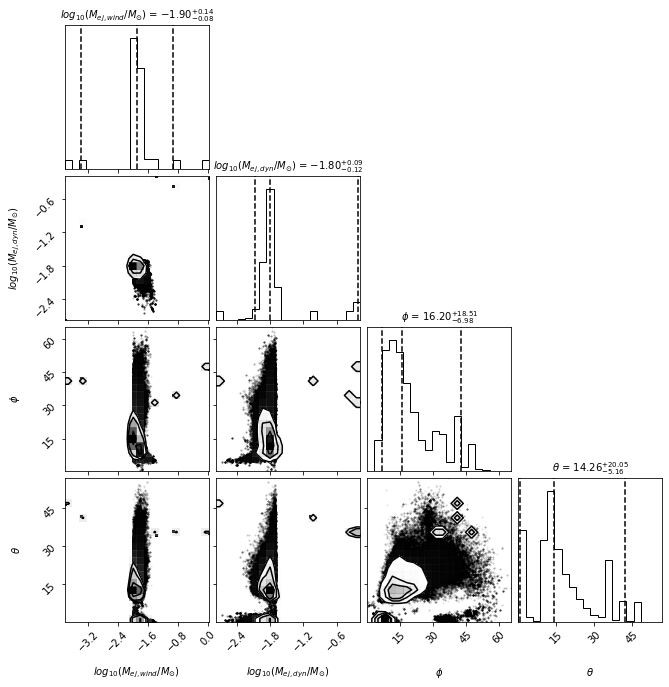

In [75]:
figure = corner.corner(samples,labels=[r"$log_{10}(M_{ej,wind}/M_{\odot})$", r"$log_{10}(M_{ej,dyn}/M_{\odot})$", r"$\phi$","$\\theta$"],
                      quantiles=[0.05, 0.5, 0.95], show_titles=True, title_kwargs={"fontsize": 10})

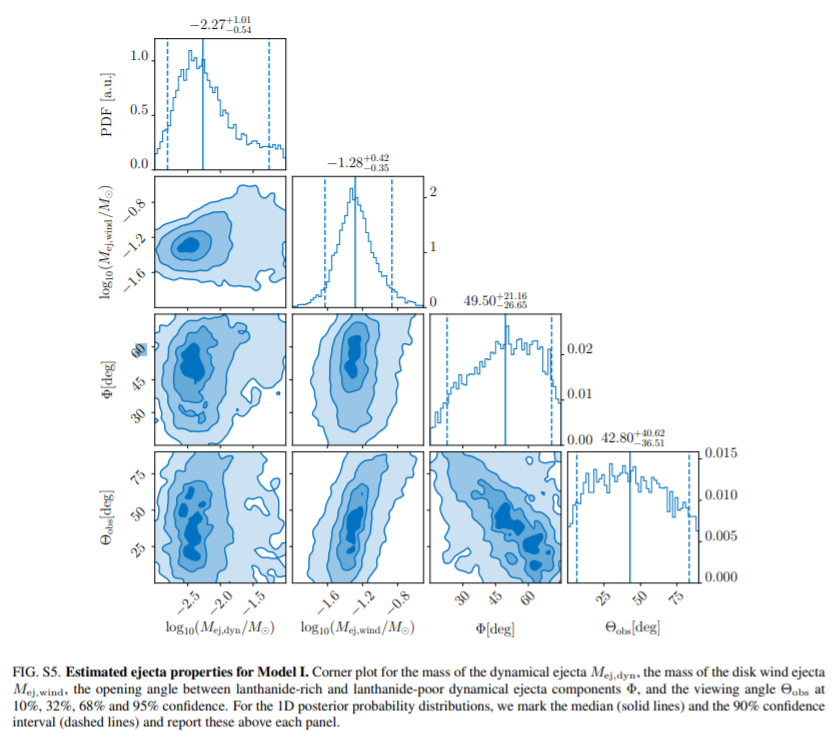

In [50]:
Image(filename='figures/Dietrich2020_ParamEst.PNG') 

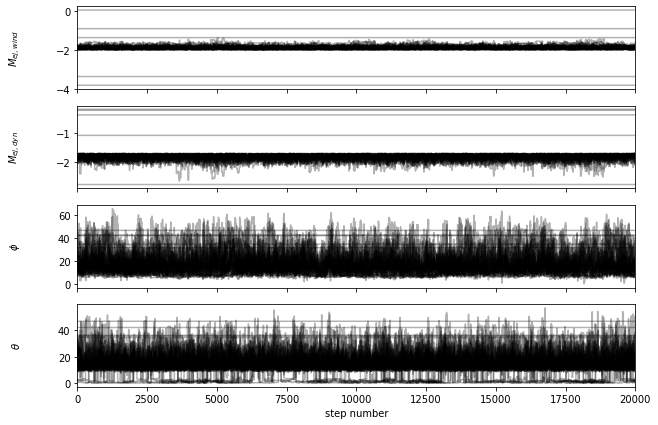

In [49]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples2 = sampler.get_chain()
labels = [r"$M_{ej,wind}$", r"$M_{ej,dyn}$", r"$\phi$","$\\theta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Here we overlay the NN lightcurve prediction from the best-fit parameter values on top of the GW 170817 KNe lightcurve data (below)

In [51]:
## get recovered parameter means and 1 sigma bounds
## [mean, upper, lower]
M_wind_stats = [np.quantile(samples[:,0],0.5), np.quantile(samples[:,0],0.16), np.quantile(samples[:,0],0.84)]
M_dyn_stats = [np.quantile(samples[:,1],0.5), np.quantile(samples[:,1],0.16), np.quantile(samples[:,1],0.84)]
phi_stats = [np.quantile(samples[:,2],0.5), np.quantile(samples[:,2],0.16), np.quantile(samples[:,2],0.84)]
theta_stats = [np.quantile(samples[:,3],0.5), np.quantile(samples[:,3],0.16), np.quantile(samples[:,3],0.84)]

In [52]:
## get NN predictions at 1 sigma
lc_pca_mean = model.predict(np.array([M_wind_stats[0],M_dyn_stats[0],phi_stats[0],theta_stats[0]]).reshape(1,-1))[0,:]

In [53]:
## reconstruct lightcurves
## this used to need to be a loop but we changed it and no it's just an unecessary single loop, sorry
lc_mean = {}
dictlist = [lc_mean]
NNlist = [lc_pca_mean]
for lcdict, pca in zip(dictlist,NNlist): 
    ## split PCA by band
    PCA_list = np.array_split(pca,len(filts))

    ## out of order b/c it needs to match NN
    pca_uBand_back = pca_uBand.inverse_transform(PCA_list[2])
    pca_gBand_back = pca_gBand.inverse_transform(PCA_list[1])
    pca_rBand_back = pca_rBand.inverse_transform(PCA_list[3])
    pca_iBand_back = pca_iBand.inverse_transform(PCA_list[0])
    pca_zBand_back = pca_zBand.inverse_transform(PCA_list[4])
    pca_yBand_back = pca_yBand.inverse_transform(PCA_list[5])
    pca_JBand_back = pca_JBand.inverse_transform(PCA_list[6])
    pca_HBand_back = pca_HBand.inverse_transform(PCA_list[7])
    pca_KBand_back = pca_KBand.inverse_transform(PCA_list[8])

    lcdict.update(dict(zip(filts,[pca_uBand_back,pca_gBand_back,pca_rBand_back,pca_iBand_back,pca_zBand_back,pca_yBand_back,\
                           pca_JBand_back,pca_HBand_back,pca_KBand_back])))

Below, we plot the NN-reconstructed lightcurve corresponding to the mean recovered parameter values. As you can see, the NIR bands tend to fit quite well, but the analysis tends to overshoot the lightcurve magnitude in the optical. We're not sure why. In any case, the observed data falls within the expected error bounds for our analysis.

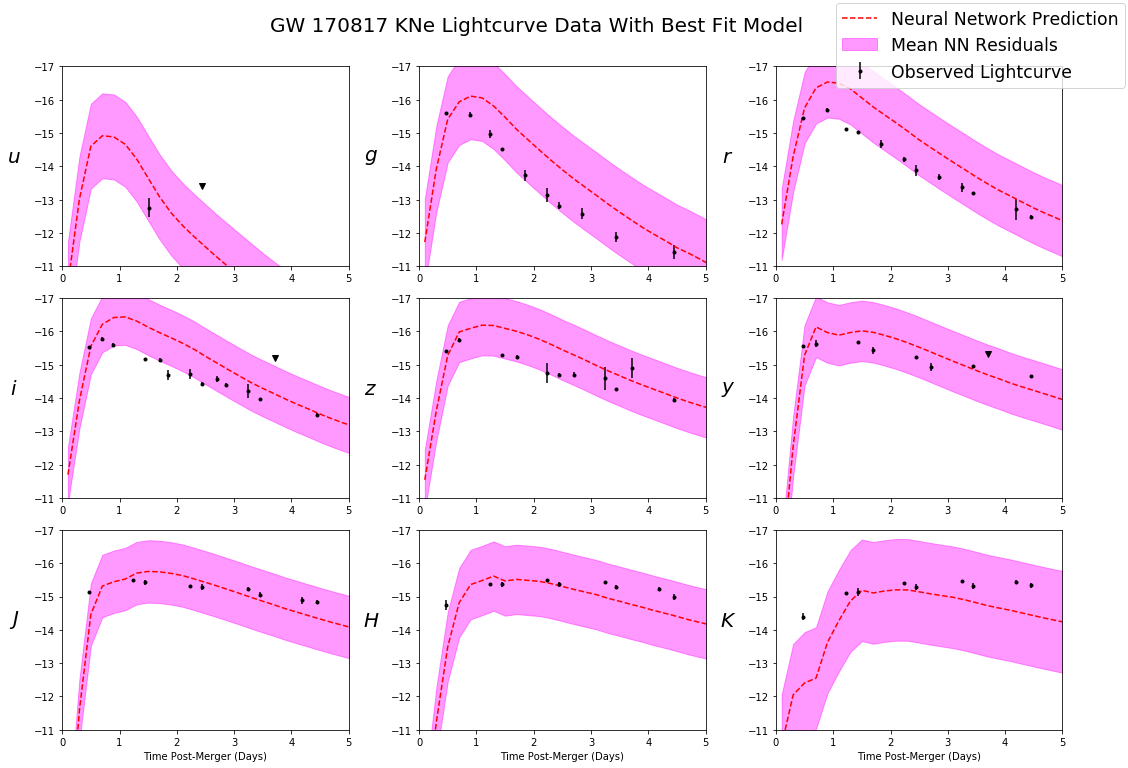

In [65]:
## plot the KNe lightcurves
fig, axes = plt.subplots(3,3,figsize=(15,10))
for err, filt, ax in zip(err_mean_arr,filts,axes.flatten()):

    data = data_out[filt]
    t, y, sigma_y = data[:,0], data[:,1], data[:,2]
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]
    idx = np.where(np.isfinite(sigma_y))[0]
    p1 = ax.errorbar(t[idx],y[idx],sigma_y[idx],fmt='.',color='k')

    idx = np.where(~np.isfinite(sigma_y))[0]
    ax.errorbar(t[idx],y[idx],sigma_y[idx],fmt='v',color='k')

    ## add best fit curve with error bounds reflecting the NN's reconstruction error
    upperbound = lc_mean[filt] + err
    lowerbound = lc_mean[filt] - err
    f1 = ax.fill_between(tt,upperbound,lowerbound,alpha=0.4,color='magenta')
    l1, = ax.plot(tt,lc_mean[filt],c='red',linestyle='--')
    
    ax.set_xlim([0.0, 5])
    ax.set_ylim([-17.0,-11.0])
    ax.invert_yaxis()
    
    ax.set_ylabel(r'$%s$'%filt,fontsize=20,rotation=0,labelpad=20)
fig.suptitle('GW 170817 KNe Lightcurve Data With Best Fit Model',fontsize=20,y=1.05)
p1.set_label('Observed Lightcurve')
l1.set_label('Neural Network Prediction')
f1.set_label('Mean NN Residuals')
fig.legend(fontsize='xx-large',loc='upper right',bbox_to_anchor=(1.05,1.075))
for ax in axes[2,:]:
    ax.set_xlabel('Time Post-Merger (Days)')
plt.tight_layout()
plt.show()

## Efficiency Calculations

Below we find the time difference between the neural network and GPR for lightcurve interpolation.

In [68]:
time_arr = np.zeros(1000)
for i in range(len(time_arr)):
    startTime = time.time()
    model_lightcurve = model.predict(np.array([-1,-2,30,30]).reshape(1,-1))[0,:]

    bands = ['i','g','u','r','z','y','J','H','K']

    ## split PCA by band
    PCA_list = np.array_split(model_lightcurve,len(bands))

    ## initialize logp
    logp = 0

    recon_err = .1 ## reconstruction error; assume gaussian (placeholder)  

    ## out of order b/c it needs to match NN
    pca_uBand_back = pca_uBand.inverse_transform(PCA_list[2])
    pca_gBand_back = pca_gBand.inverse_transform(PCA_list[1])
    pca_rBand_back = pca_rBand.inverse_transform(PCA_list[3])
    pca_iBand_back = pca_iBand.inverse_transform(PCA_list[0])
    pca_zBand_back = pca_zBand.inverse_transform(PCA_list[4])
    pca_yBand_back = pca_yBand.inverse_transform(PCA_list[5])
    pca_JBand_back = pca_JBand.inverse_transform(PCA_list[6])
    pca_HBand_back = pca_HBand.inverse_transform(PCA_list[7])
    pca_KBand_back = pca_KBand.inverse_transform(PCA_list[8])

    PCA_list_transformed = [pca_uBand_back,pca_gBand_back,pca_rBand_back,pca_iBand_back,pca_zBand_back,pca_yBand_back,\
                               pca_JBand_back,pca_HBand_back,pca_KBand_back]

    ## loop over magnitude bands
    for band, PCA in zip(bands,PCA_list_transformed):
        ## extract times, magnitudes, and errors
        times = data_reproc[band][:,0]
        mags = data_reproc[band][:,1]
        mag_errs = data_reproc[band][:,2]
        ## reconstruct lightcurve from NN PCA (how?? Rui help)
        lc_model = PCA
        lc_times = tt
        f_interp = interp.interp1d(lc_times,lc_model,fill_value='extrapolate')
        ## compute predicted lightcurve values at GW170817 observation times
        lc_obs_pred = f_interp(times)
    executionTime = (time.time() - startTime)
    time_arr[i] = executionTime
print('Average time per reconstruction is '+str(np.mean(time_arr)))

Average time per reconstruction is 0.0014258310794830322


In [69]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, RationalQuadratic
n_coeff = 3 

In [70]:
def loadEvent(filename):
    lines = [line.rstrip('\n') for line in open(filename)]
    lines = filter(None,lines)

    data = {}
    for line in lines:
        lineSplit = line.split(" ")
        lineSplit = list(filter(None,lineSplit))
        mjd = Time(lineSplit[0], format='isot').mjd
        filt = lineSplit[1]
        mag = float(lineSplit[2])
        dmag = float(lineSplit[3])

        if not filt in data:
            data[filt] = np.empty((0,3), float)
        data[filt] = np.append(data[filt],np.array([[mjd,mag,dmag]]),axis=0)

    return data 
    
filename = "data/GW170817.dat"
T0 = 57982.5285236896 # Merger time
distance = 40

data_out = loadEvent(filename)

for ii,key in enumerate(list(data_out.keys())):
    if key == "t":
        continue
    else:
        data_out[key][:,0] = data_out[key][:,0] - T0
        data_out[key][:,1] = data_out[key][:,1] - 5*(np.log10(distance*1e6) - 1)

for ii,key in enumerate(list(data_out.keys())):
    if key == "t":
        continue
    else:
        idxs = np.intersect1d(np.where(data_out[key][:,0]>=tini)[0],np.where(data_out[key][:,0]<=tmax)[0])
        data_out[key] = data_out[key][idxs,:]

for ii,key in enumerate(list(data_out.keys())):
    idxs = np.where(~np.isnan(data_out[key][:,2]))[0]
    if key == "t":
        continue
    else:
        data_out[key] = data_out[key][idxs,:]

for ii,key in enumerate(list(data_out.keys())):
    if not key in filts:
        del data_out[key]



In [71]:
param_array = []
for key in modelkeys:
    if objtype == "BNS":
        param_array.append([np.log10(models[key]["mej_dyn"]),np.log10(models[key]["mej_wind"]),models[key]["phi"],models[key]["theta"]])
    elif objtype == "NSBH":
        param_array.append([np.log10(models[key]["mej_dyn"]),np.log10(models[key]["mej_wind"]),models[key]["theta"]])
param_array_postprocess = np.array(param_array)
        

param_mins, param_maxs = np.min(param_array_postprocess,axis=0),np.max(param_array_postprocess,axis=0)
for i in range(len(param_mins)):
    param_array_postprocess[:,i] = (param_array_postprocess[:,i]-param_mins[i])/(param_maxs[i]-param_mins[i])

In [72]:
new_svd_model = {}
# Loop through filters
for jj,filt in enumerate(filts):
    print('Normalizing mag filter %s...' % filt)
    mag_array = []
    for key in modelkeys:
        mag_array.append(models[key]["data"][:,jj])

    mag_array_postprocess = np.array(mag_array)
    mins,maxs = np.min(mag_array_postprocess,axis=0),np.max(mag_array_postprocess,axis=0)
    for i in range(len(mins)):
        mag_array_postprocess[:,i] = (mag_array_postprocess[:,i] - mins[i])/(maxs[i] - mins[i])
    mag_array_postprocess[np.isnan(mag_array_postprocess)]=0.0
    
    new_svd_model[filt] = {}
    new_svd_model[filt]["param_array"] = param_array
    new_svd_model[filt]["param_mins"] = param_mins
    new_svd_model[filt]["param_maxs"] = param_maxs
    new_svd_model[filt]["mins"] = mins
    new_svd_model[filt]["maxs"] = maxs
    new_svd_model[filt]["tt"] = tt
    new_svd_model[filt]["mag_array_postprocess"] = mag_array_postprocess

Normalizing mag filter u...
Normalizing mag filter g...
Normalizing mag filter r...
Normalizing mag filter i...
Normalizing mag filter z...
Normalizing mag filter y...
Normalizing mag filter J...
Normalizing mag filter H...
Normalizing mag filter K...


In [73]:
for jj,filt in enumerate(filts):
    print('Computing PCA for filter %s...' % filt)

    mag_array_postprocess = new_svd_model[filt]["mag_array_postprocess"] 
    UA, sA, VA = np.linalg.svd(mag_array_postprocess)# compute the SVD
    VA = VA.T

    n, n = UA.shape
    m, m = VA.shape

    cAmat = np.zeros((n_coeff,n))
    cAvar = np.zeros((n_coeff,n))
    for i in range(n):
        ErrorLevel = 1.0
        VA_principal = VA[:,:n_coeff]
        cAmat[:,i] = np.dot(mag_array_postprocess[i,:],VA_principal)# prepare the array of target values (hint: remember this is the dot product of your data with V)
        errors = ErrorLevel*np.ones_like(mag_array_postprocess[i,:])
        cAvar[:,i] = np.diag(np.dot(VA_principal.T, np.dot(np.diag(np.power(errors,2.)), VA_principal)))# calculate the variance in the target array (hint: remember this is V^T E^2 V)
    cAstd = np.sqrt(cAvar)

    new_svd_model[filt]["n_coeff"] = n_coeff
    new_svd_model[filt]["cAmat"] = cAmat
    new_svd_model[filt]["cAstd"] = cAstd
    new_svd_model[filt]["VA"] = VA  

Computing PCA for filter u...
Computing PCA for filter g...
Computing PCA for filter r...
Computing PCA for filter i...
Computing PCA for filter z...
Computing PCA for filter y...
Computing PCA for filter J...
Computing PCA for filter H...
Computing PCA for filter K...


In [76]:
startTime = time.time()
for jj,filt in enumerate(filts):
    print('Computing GP for filter %s...' % filt)

    cAmat = new_svd_model[filt]["cAmat"]
    cAstd = new_svd_model[filt]["cAstd"]
    VA = new_svd_model[filt]["VA"]
    
    nsvds, nparams = param_array_postprocess.shape
    
    # Set of Gaussian Process
    kernel = RationalQuadratic()# Choose a kernel: I used RationalQuadratic
    gps = []
    for i in range(n_coeff):
        if np.mod(i,1) == 0:
            print('Coefficient %d/%d...' % (i+1, n_coeff))
        
        gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=0)# Run GaussianProcessRegressor with your chosen kernel
        gp.fit(param_array_postprocess, cAmat[i,:]) # fit your parameters to your computed PCA coefficients
        gps.append(gp)
        
    new_svd_model[filt]["gps"] = gps
    
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
num_of_models = len(modelkeys)
print('Execution time per model in seconds: ' + str(executionTime/num_of_models))

Computing GP for filter u...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter g...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter r...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter i...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter z...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter y...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter J...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter H...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Computing GP for filter K...
Coefficient 1/3...
Coefficient 2/3...
Coefficient 3/3...
Execution time in seconds: 1861.7241749763489
Execution time per model in seconds: 0.8635084299519243


The time for the GPR is difficult to calculate directly for each model.  So, I found the time for all the models and then divided it by the total number of models.  As we see, GPR takes a significantly longer time than the neural network does.  

# Conclusion and Discussion

### Highlights

- We created a neural network that can accurately recreate KNe lightcurve models for any combination of the relevant parameters.
- To do so, we performed dimensionality reduction via PCA, allowing us to simultaneously recreate lightcurves for all 9 bands across the optical and infrared.
- This approach is faster than the traditional method of Gaussian Process Regression by almost an order of magnitude, allowing for much more efficient use of MCMC and other sampling methods.
- We used the neural network in a Bayesian parameter estimation scheme to find the best fit parameters for the KNe counterpart to GW170817, recovering values consistent with published results.

### Future Work

- We are in the process of characterizing the NN's prediction and reconstruction error to better reflect this error in our parameter estimation process. This will allow us to be more confident that our parameter recoveries are accurate.
